##### Introduction

This notebook demonstrates how to use the WordCloud class from the Shekar library to generate Persian word clouds with proper font rendering, reshaping, and masking. It supports right-to-left scripts by integrating arabic_reshaper and python-bidi, ensuring that Persian words appear in their correct visual form.

You can customize the word cloud using different fonts, color maps, and mask shapes such as the map of Iran, a heart, a light bulb, or even your own image file.

To install Shekar, run the following cell:

In [16]:
!pip install shekar -U

##### Data Prepration

In this example, we'll create a Persian word cloud from the short story "فارسی شکر است" by Mohammad Ali Jamalzadeh. We'll start by downloading the story from an online source and inspecting the raw HTML response to understand its structure before preprocessing the content.

In [17]:
import requests

url = f"https://ganjoor.net/ferdousi/shahname/siavosh/sh9"
response = requests.get(url)
html_content = response.text
print(html_content[0:1000])


<!DOCTYPE html>
<html lang="fa-IR" dir="rtl">
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <title>
        گنجور » فردوسی » شاهنامه » داستان سیاوش » بخش ۹
    </title>
    <link href="https://fonts.googleapis.com/css2?family=Vazirmatn:wght@400;500;700&display=swap" rel="stylesheet">
    <link href="/css/p8.css?version=82" rel="stylesheet" type="text/css">
    <link rel="shortcut icon" href="/favicon.ico?version=1" type="image/x-icon">
    <link rel="search" type="application/opensearchdescription+xml" title="گنجور" href="https://ganjoor.net/search.xml">
    <script src="/lib/jquery/dist/jquery.min.js"></script>
    <script src="/js/chart.js"></script>
    <script src="/js/bk.js?version=78"></script>
    <script src="/js/jquery.mark.min.js"></script>
    <script>
        var cookieValue = getCookie("playerScrollLock");
        var playerScrollLock = cookieValue === "true";

        cookieValue = getC


After fetching the story, we are left with a wall of raw HTML filled with tags, extra symbols, and irrelevant characters. It's not something we can feed directly into a word cloud generator. We need to clean the text and bring it into shape.

To do this, we use Shekar's built-in text transformers. These are modular components designed to handle specific cleaning tasks. By chaining them together, we build a preprocessing pipeline that takes care of the messy content for us.

Here's what each component in the pipeline does:

- **HTMLTagRemover** strips out all HTML elements like &lt;div&gt;, &lt;span&gt;, and other tags that do not belong in the actual text.

- **DiacriticsRemover** removes short vowels and other diacritical marks that are often unnecessary in Persian text analysis.

- **PunctuationRemover** takes care of punctuation symbols such as commas, question marks, and periods.

- **StopWordRemover** eliminates common Persian stop words that appear frequently but add little meaning in word frequency analysis.

- **NonPersianRemover** removes any character that is not part of the Persian alphabet, such as Latin letters or digits.

Once the text is cleaned, we apply a couple of normalization steps:

- **ArabicUnicodeNormalizer** replaces Arabic characters that look similar but have different Unicode values with their standard Persian equivalents.

- **SpacingStandardizer** corrects spacing issues, ensuring that words are properly separated and no extra whitespace is present.

Together, these steps form a complete preprocessing pipeline:

In [18]:
from shekar.preprocessing import (
  HTMLTagRemover,
  DiacriticsRemover,
  PunctuationRemover,
  StopWordRemover,
  NonPersianRemover,
  ArabicUnicodeNormalizer,
  SpacingStandardizer,
)
cleaners = HTMLTagRemover() | DiacriticsRemover() | PunctuationRemover() | StopWordRemover() | NonPersianRemover()
normalizers = ArabicUnicodeNormalizer() | SpacingStandardizer()

preprocessing_pipeline = cleaners | normalizers

In [19]:
clean_text = preprocessing_pipeline(html_content)
print(clean_text[0:1000])

گنجور فردوسی شاهنامه داستان سیاوش ۹ فردوسی شاهنامه داستان سیاوش ۹ آثار همه سخنوران آذر بیگدلی آشفته شیرازی ابن حسام خوسفی ابن عماد ابن یمین ابوالحسن فراهانی ابوالفرج رونی ابوالفضل بیهقی ابوسعید ابوالخیر ابوعلی عثمانی اثیر اخسیکتی ادیب الممالک ادیب صابر ازرقی هروی اسدی توسی اسیر شهرستانی اسیری لاهیجی افسر کرمانی افسرالملوک عاملی اقبال لاهوری الهامی کرمانشاهی امامی هروی امیر پازواری امیر حسینی هروی امیر شاهی امیر معزی امیرخسرو دهلوی امیرعلیشیر نوایی انوری اوحدالدین کرمانی اوحدی اهلی شیرازی ایرانشان ایرج میرزا باباافضل کاشانی باباطاهر بابافغانی بلند اقبال بهاء ولد بیدل دهلوی پروین اعتصامی ترکی شیرازی جامی جلال عضد جمال‌الدین عبدالرزاق جویای تبریزی جهان ملک خاتون جیحون یزدی حاجب شیرازی حافظ حزین لاهیجی حسین خوارزمی حکیم سبزواری حکیم نزاری حمیدالدین بلخی حیدر شیرازی خاقانی خالد نقشبندی خلیل‌الله خلیلی خواجوی کرمانی خواجه عبدالله انصاری خواجه نصیرالدین طوسی خیالی بخارایی خیام دقیقی رشحه رضاقلی خان هدایت رضی‌الدین آرتیمانی رفیق اصفهانی رودکی رهی معیری سام میرزا صفوی سحاب اصفهانی سراج قمری سرا

Now that the raw HTML has taken a spin through our text-washing machine, it's fresh, clean, and neatly pressed. All set and ready to shine in a beautiful Persian word cloud!

#### Creating Persian Word Clouds

Now that we’ve cleaned and prepared our text, it’s time to bring the words to life with a beautiful Persian word cloud. The **WordCloud** class in Shekar provides a flexible and culturally aware way to visualize word frequencies, with built-in support for Persian fonts, character reshaping, and optional masks.

##### Parameters You Can Customize


| Parameter          | Description                                                                                                                              |
| ------------------ | ---------------------------------------------------------------------------------------------------------------------------------------- |
| `mask`             | Optional shape mask for the word cloud. Use `"Iran"`, `"Heart"`, `"Bulb"`, `"Cat"`, `"Cloud"`, `"Head"`, or provide a custom image path. If *None* it will generate a rectangle. |
| `font`             | Font to use. Choose `"sahel"` or `"parastoo"`, or provide a custom TTF font path.                                                        |
| `width`, `height`  | Size of the generated image in pixels. Ignored if mask provided.                                                                                                  |
| `bg_color`         | Background color (e.g., `"white"`, `"black"`).                                                                                           |
| `contour_color`    | Outline color of the mask shape.                                                                                                         |
| `contour_width`    | Thickness of the outline.                                                                                                                |
| `color_map`        | Matplotlib color map for the words (e.g., `"viridis"`, `"plasma"`, `"Greens"`).                                                          |
| `min_font_size`    | Minimum font size in the word cloud.                                                                                                     |
| `max_font_size`    | Maximum font size in the word cloud.                                                                                                     |
| `horizontal_ratio` | Controls how many words appear horizontally. A value between `0.0` and `1.0` (default is `0.75`).                                        |


##### Generating a Word Cloud for "فارسی شکر است"
We’ll tokenize the cleaned text, count word frequencies, and pass them to the WordCloud generator:

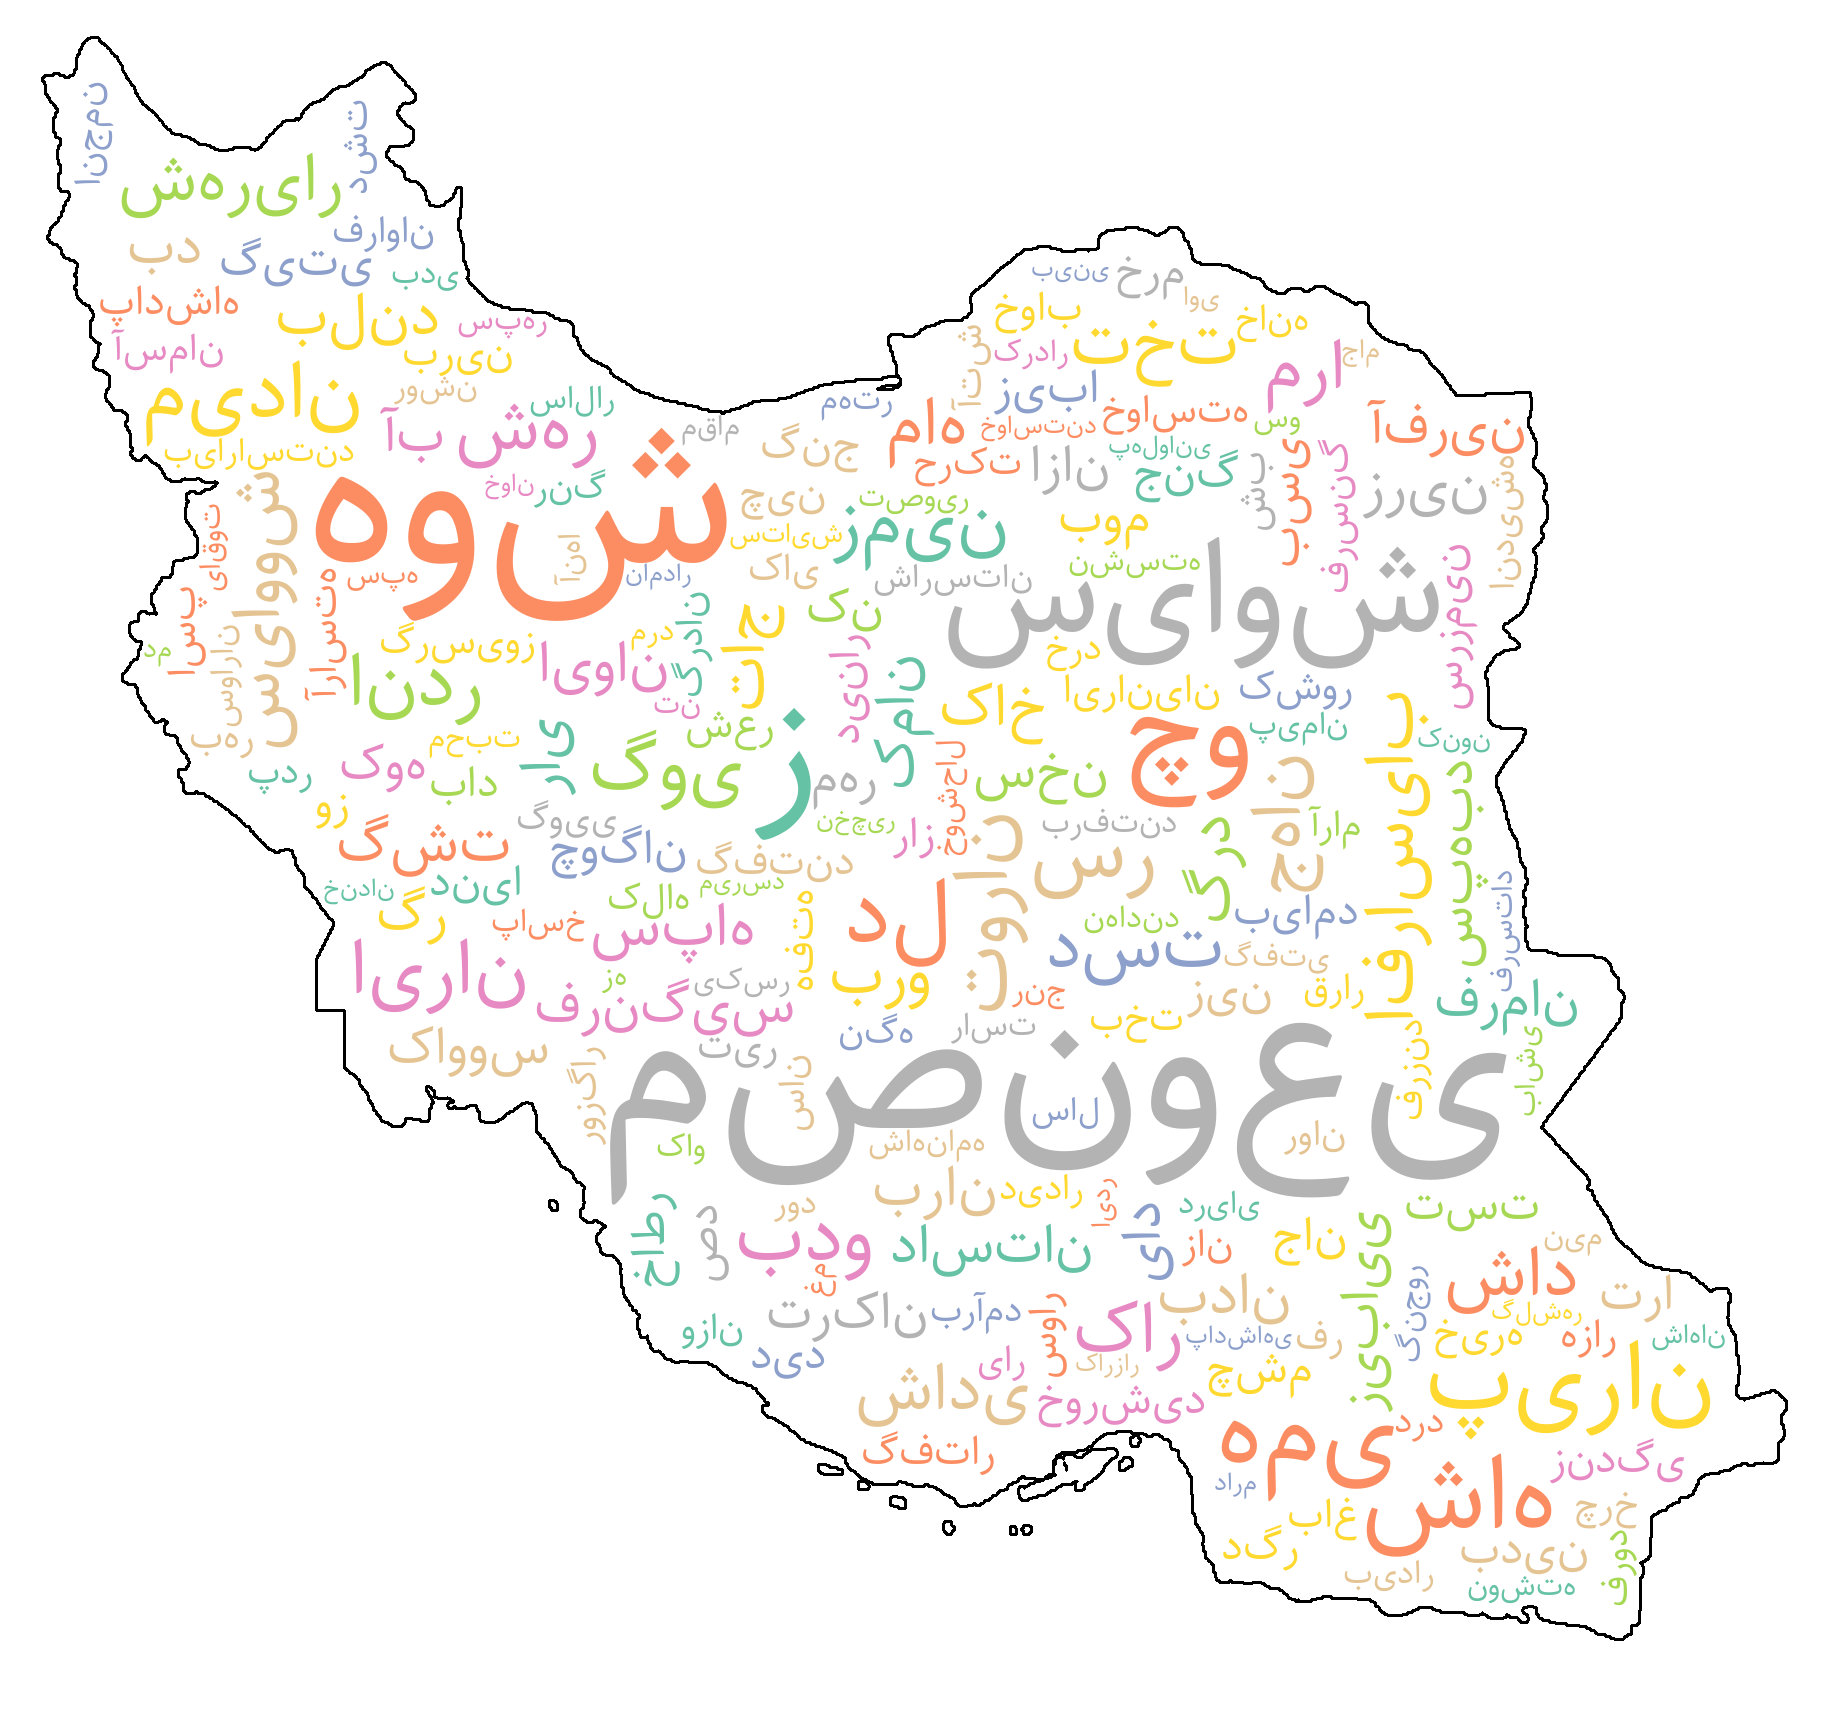

In [20]:
from shekar import WordCloud
from collections import Counter
from shekar import WordTokenizer


word_tokenizer = WordTokenizer()
tokens = word_tokenizer(clean_text)

word_freqs = Counter()
for word in tokens:
    word_freqs[word] += 1


wordCloud = WordCloud(
        mask="Iran",
        width=1000,
        height=500,
        max_font_size=220,
        min_font_size=5,
        bg_color="white",
        contour_color="black",
        contour_width=3,
        color_map="Set2",
    )

# if shows disconnect words, try again with bidi_reshape=True
image = wordCloud.generate(word_freqs, bidi_reshape=False)
image

Pretty cool, huh? Now that you’ve seen it in action, feel free to play around with the settings and explore different configurations. Change the mask shape, switch up the color map, or try a new font to see how each adjustment transforms the final word cloud. It’s a fun way to experiment and discover the visual style that works best for your text.

##### Using a Custom Mask

Want to make your word cloud even more personalized? You can provide your own custom shape by passing the path to a binary mask image file. This allows you to generate word clouds that fit any silhouette you like, whether it's a logo, symbol, or artistic design!

##### How It Works
A mask is simply a black-and-white image where:
- The black (0) areas define the regions where words can appear.
- The white (255) areas will be left blank.
This binary image acts like a stencil for your word cloud.

##### Example
Let’s say you have a custom shape saved as cat.png, which is a black-and-white silhouette of a cat. We’ll start by loading and visualizing the mask image, then use it to generate a word cloud.

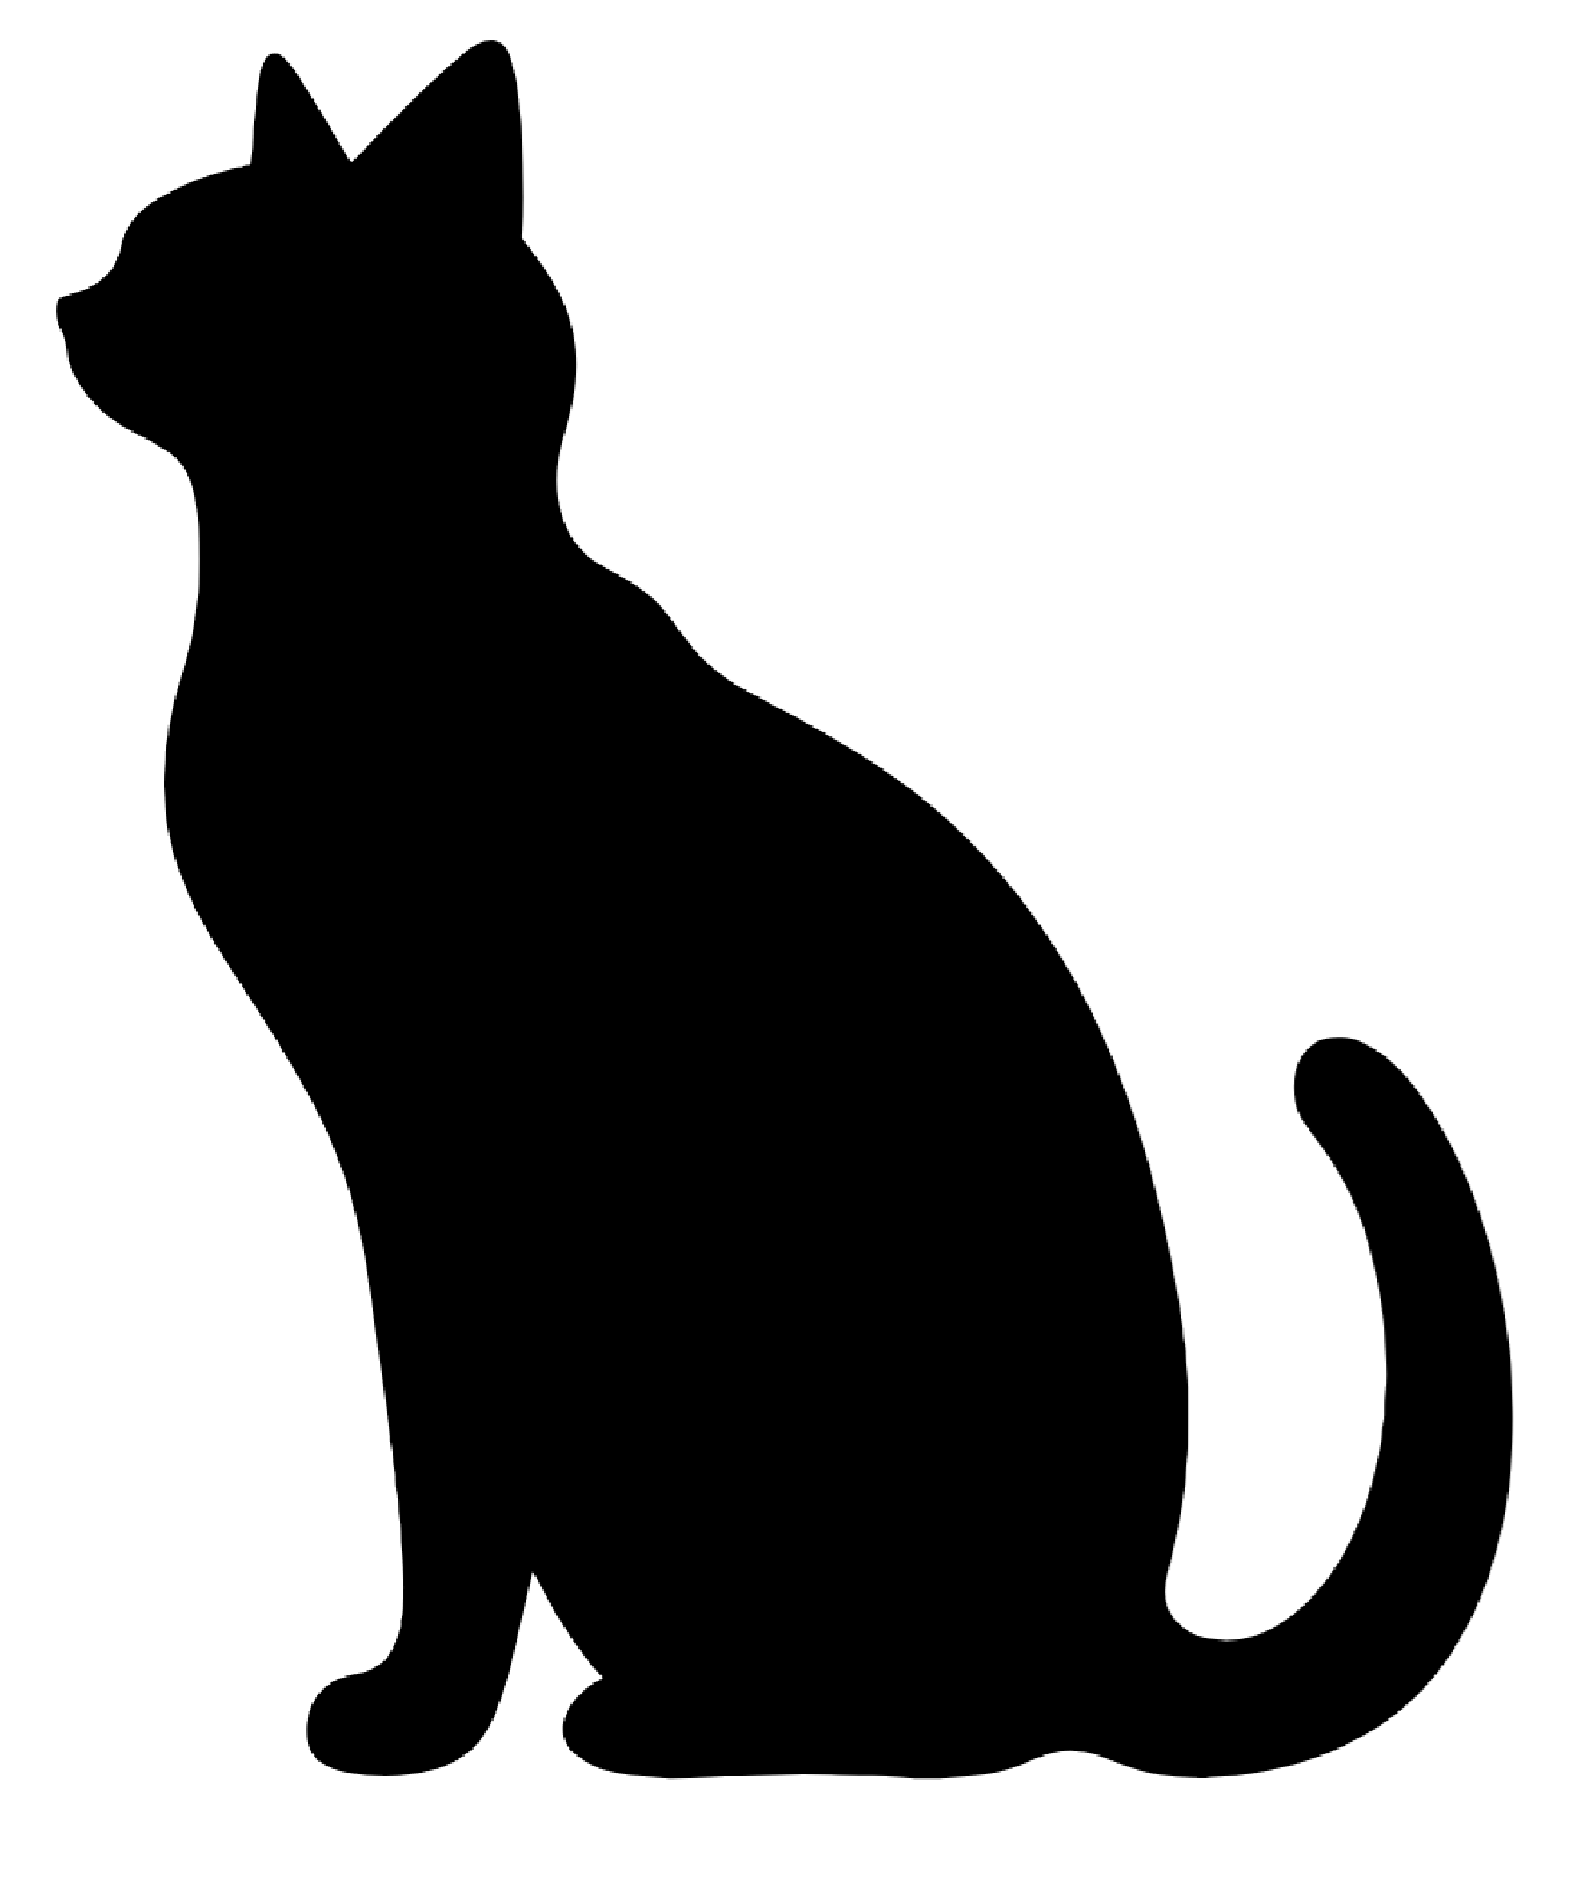

In [21]:
from PIL import Image
from shekar import data
from importlib import resources

mask_path  = resources.files(data).joinpath("masks") / "cat.png"
mask_image = Image.open(mask_path)
mask_image

The black areas in the mask are where the words will be placed. White or transparent areas will remain empty in the final image.

**Generate Word Cloud with the Custom Mask**

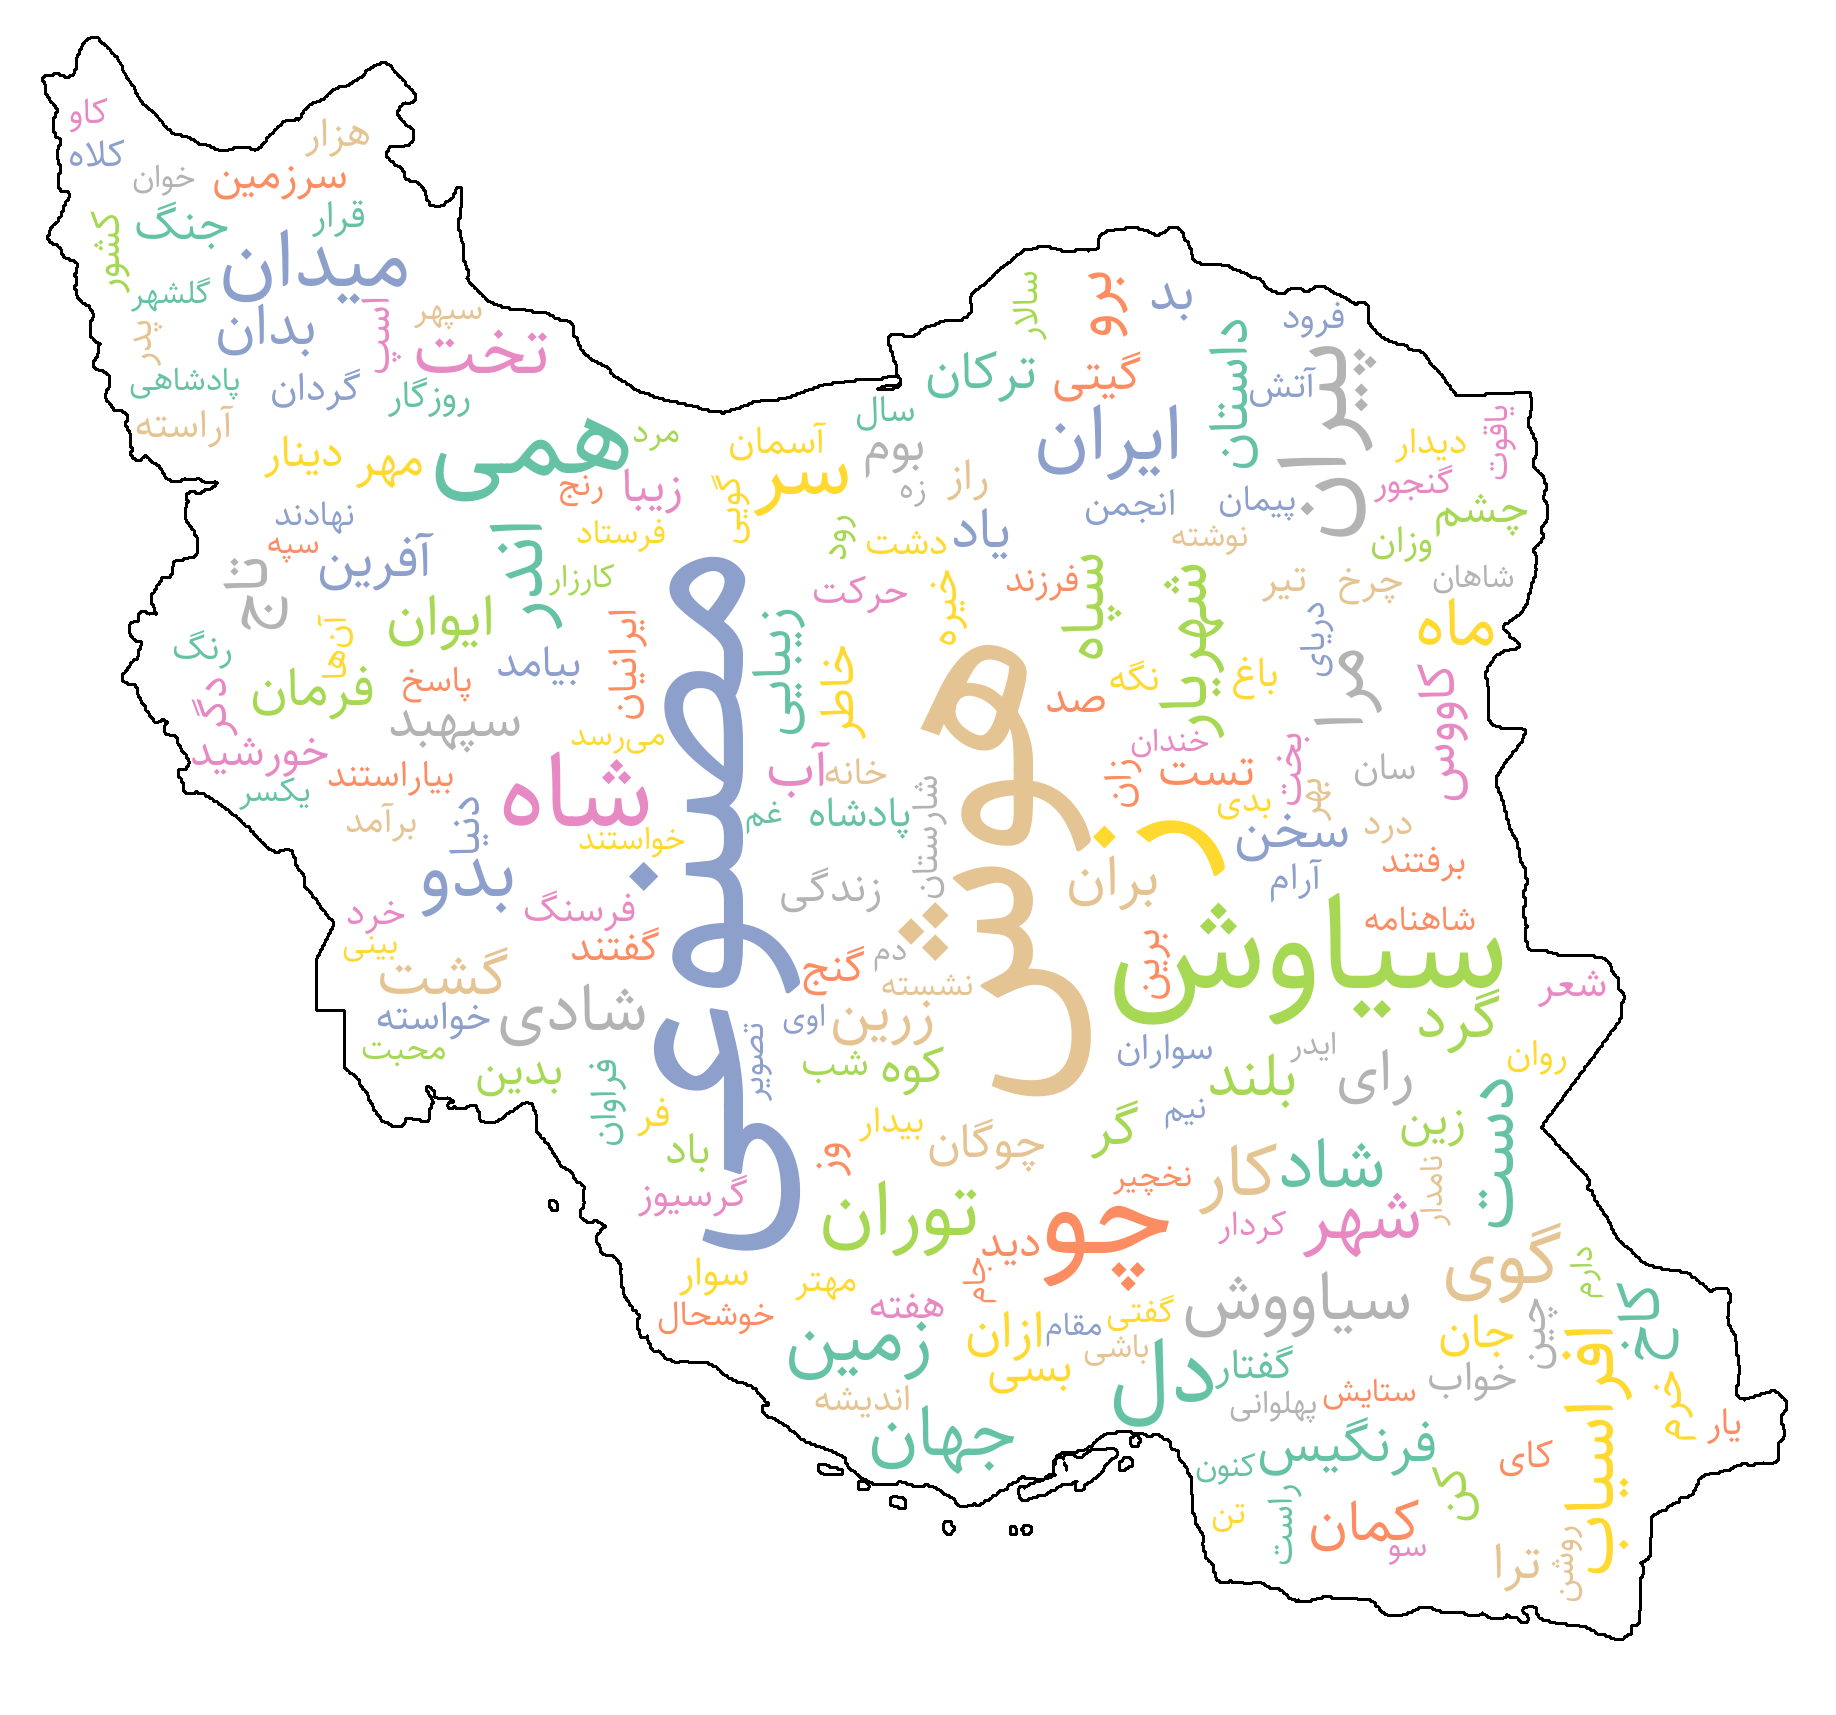

In [ ]:
cat_wordcloud = WordCloud(
    mask=str(mask_path),
    font="sahel",
    color_map="cool",
    bg_color="black",
    contour_color="black",
    contour_width=4,
    min_font_size=8,
    max_font_size=120,
    horizontal_ratio=0.90
)

# if shows disconnect words, try again with bidi_reshape=True
image = wordCloud.generate(word_freqs, bidi_reshape=False)
image

**Tips for Creating Your Own Mask**

- Use a black-and-white PNG with a white background.
- Make sure the black area forms a clear, continuous shape.
- Avoid overly detailed or thin designs for better word visibility.

With a custom mask, your word clouds can reflect your project’s theme, brand, or creative vision.